In [1]:
# 2021-01-17 - try to run PY's new saturation stacker
# 
# THis is all pasted from a prototype notebook Peter Yoachim produced in response to queries.
#
# 2021-02-18 UPDATED with a corrected saturation stacker. That stacker is in the github sims_maf
# now but I don't know if it's yet propagated into the sims_maf on Sciserver or Datalab. So, the 
# updated version is pasted here.

In [2]:
# import python pieces
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp



In [3]:
# import lsst-relevant stuff
import lsst.sims.maf.stackers as stackers

In [4]:
### 2021-02-18 update: pasted from the corrected saturationStacker now in MAF (not sure if it's 
### on the sciserver MAF yet)
class SaturationStacker(stackers.BaseStacker):
    """Calculate the saturation limit of a point source. Assumes Guassian PSF.
    
    Parameters
    ----------
    pixscale : float, opt (0.2)
        Arcsec per pixel
    gain : float, opt (2.3)
        electrons per adu
    saturation_e : float, opt (150e3)
        The saturation level in electrons
    zeropoints : dict-like, opt (None)
        The zeropoints for the telescope. Keys should be str with filter names, values in mags.
        If None, will use Rubin-like zeropoints.
    km : dict-like, opt (None)
        Atmospheric extinction values.  Keys should be str with filter names. If None, will use Rubin-like zeropoints.
    """
    colsAdded = ['saturation_mag']

    def __init__(self, seeingCol='seeingFwhmEff', skybrightnessCol='skyBrightness',
                 exptimeCol='visitExposureTime', nexpCol='numExposures',
                 filterCol='filter', airmassCol='airmass',
                 saturation_e=150e3, zeropoints=None, km=None, pixscale=0.2, gain=1.0):
        self.units = ['mag']
        self.colsReq = [seeingCol, skybrightnessCol, exptimeCol, nexpCol, filterCol, airmassCol]
        self.seeingCol = seeingCol
        self.skybrightnessCol = skybrightnessCol
        self.exptimeCol = exptimeCol
        self.nexpCol = nexpCol
        self.filterCol = filterCol
        self.airmassCol = airmassCol
        self.saturation_adu = saturation_e/gain
        self.pixscale = 0.2
        names = ['u', 'g', 'r', 'i', 'z', 'y']
        types = [float]*6
        if zeropoints is None:
            # Note these zeropoints are calculating the number of *electrons* per second (thus gain=1)
            # https://github.com/lsst-pst/syseng_throughputs/blob/master/notebooks/Syseng%20Throughputs%20Repo%20Demo.ipynb
            self.zeropoints = np.array([27.03, 28.38, 28.15, 27.86, 27.46, 26.68]).view(list(zip(names, types)))
            self.saturation_adu = saturation_e 
        else:
            self.zeropoints = zeropoints

        if km is None:
            # Also from notebook above
            self.km = np.array([0.491, 0.213, 0.126, 0.096, 0.069, 0.170]).view(list(zip(names, types)))
        else:
            self.km = km

    def _run(self, simData, cols_present=False):
        for filtername in np.unique(simData[self.filterCol]):
            in_filt = np.where(simData[self.filterCol] == filtername)[0]
            # Calculate the length of the on-sky time per EXPOSURE
            exptime = simData[self.exptimeCol][in_filt] / simData[self.nexpCol][in_filt]
            # Calculate sky counts per pixel per second from skybrightness + zeropoint (e/1s)
            sky_counts = 10.**(0.4*(self.zeropoints[filtername] - simData[self.skybrightnessCol][in_filt])) * self.pixscale**2
            # Total sky counts in each exposure 
            sky_counts = sky_counts * exptime
            # The counts available to the source (at peak) in each exposure is the difference between saturation and sky
            remaining_counts_peak = (self.saturation_adu - sky_counts)
            # Now to figure out how many counts there would be total, if there are that many in the peak
            sigma = simData[self.seeingCol][in_filt]/2.354
            source_counts = remaining_counts_peak * 2.*np.pi*(sigma/self.pixscale)**2
            # source counts = counts per exposure (expTimeCol / nexp)
            # Translate to counts per second, to apply zeropoint 
            count_rate = source_counts / exptime
            simData['saturation_mag'][in_filt] = -2.5*np.log10(count_rate) + self.zeropoints[filtername]
            # Airmass correction
            simData['saturation_mag'][in_filt] -= self.km[filtername]*(simData[self.airmassCol][in_filt] - 1.)

        return simData

In [5]:
# set up for lsst
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles



In [6]:
# Connect to the database (on sciserver)
dbroot='/home/idies/workspace/lsst_cadence/FBS_1.5/'
conn = db.OpsimDatabase(dbroot+'short_exp_5ns_5expt_v1.5_10yrs.db')
outDir = 'satur_test'
resultsDb = db.ResultsDb(outDir=outDir)
nside = 64 


In [7]:
# Define the metric bundle and the slicer
bundleList = []

stacker = SaturationStacker()

sql = 'filter="r" and visitExposureTime > 20'
metric = metrics.MedianMetric(col='saturation_mag')
slicer = slicers.HealpixSlicer(nside=nside)
summaryStats = []
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql,
                                             plotDict=plotDict,
                                             summaryMetrics=summaryStats,
                                            stackerList=[stacker]))


sql = 'filter="r" and visitExposureTime < 20'

bundleList.append(metricBundles.MetricBundle(metric,slicer,sql,
                                             plotDict=plotDict,
                                             summaryMetrics=summaryStats,
                                            stackerList=[stacker]))

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Querying database SummaryAllProps with constraint filter="r" and visitExposureTime > 20 for columns ['airmass', 'visitExposureTime', 'skyBrightness', 'numExposures', 'fieldRA', 'fieldDec', 'filter', 'seeingFwhmEff']
Found 482646 visits
Running:  ['opsim_Median_saturation_mag_r_and_visitExposureTime_gt_20_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="r" and visitExposureTime < 20 for columns ['airmass', 'visitExposureTime', 'skyBrightness', 'numExposures', 'fieldRA', 'fieldDec', 'filter', 'seeingFwhmEff']
Found 138694 visits
Running:  ['opsim_Median_saturation_mag_r_and_visitExposureTime_lt_20_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter="r" and visitExposureTime > 20" constraint now.


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 15.0569  dipole: lon: 146.964, lat: -51.5207, amp: 0.272145
  mono, lon, lat, amp


Plotting complete.
Plotting figures with "filter="r" and visitExposureTime < 20" constraint now.


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 13.1112  dipole: lon: 159.347, lat: -39.2386, amp: 0.266245
  mono, lon, lat, amp


Plotting complete.


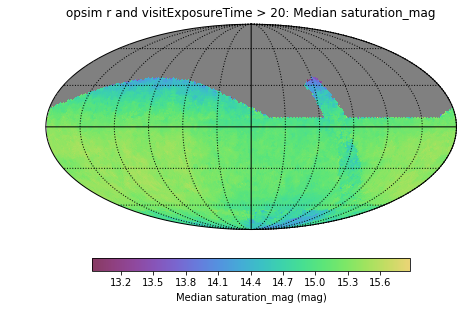

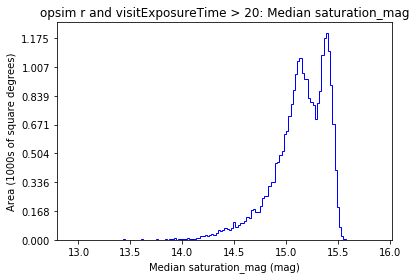

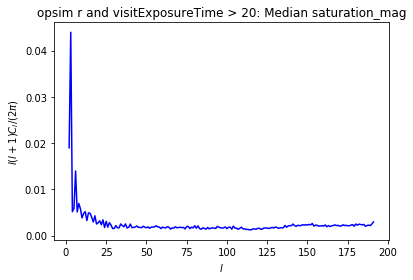

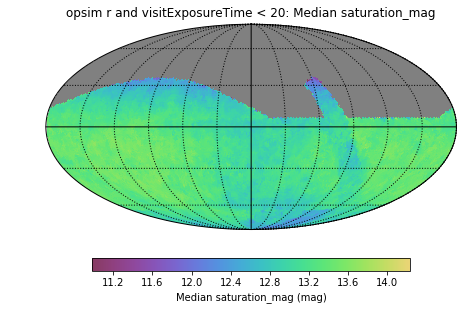

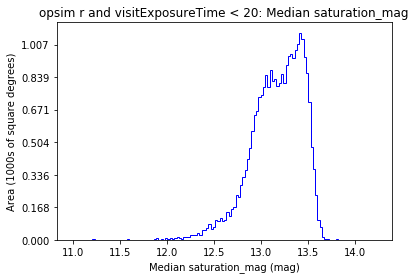

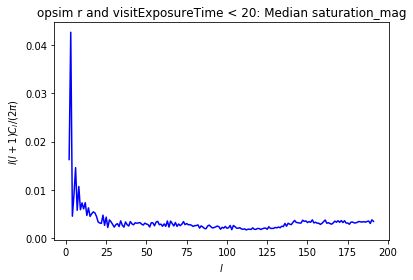

In [8]:
# actually run things
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)